In [ ]:
# install rdkit  
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c rdkit rdkit python=3.7
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import pprint     
pprint.pprint(sys.path)
!python -c "import site; print (site.getsitepackages())"

In [2]:
from rdkit import Chem
from rdkit.Chem import rdchem
import re
Chiral = {"CHI_UNSPECIFIED":0,  "CHI_TETRAHEDRAL_CW":1, "CHI_TETRAHEDRAL_CCW":2, "CHI_OTHER":3}

Hybridization = {"UNSPECIFIED":0, "S":1, "SP":2, "SP2":3, "SP3":4, "SP3D":5, "SP3D2":6, "OTHER":7}

atomInfo = 21
structInfo = 21
lensize= atomInfo + structInfo

H_Vector = [0]*atomInfo
H_Vector[0]= 1

lowerReg = re.compile(r'^[a-z]+$')
def islower(s):
    return lowerReg.match(s) is not None

upperReg = re.compile(r'^[A-Z]+$')
def isupper(s):
    return upperReg.match(s) is not None

def calc_atom_feature(atom):
    
    if atom.GetSymbol() == 'H':   feature = [1,0,0,0,0]
    elif atom.GetSymbol() == 'C': feature = [0,1,0,0,0]
    elif atom.GetSymbol() == 'O': feature = [0,0,1,0,0]
    elif atom.GetSymbol() == 'N': feature = [0,0,0,1,0]
    else: feature = [0,0,0,0,1]
        
    feature.append(atom.GetTotalNumHs()/8)
    feature.append(atom.GetTotalDegree()/4)
    feature.append(atom.GetFormalCharge()/8)
    feature.append(atom.GetTotalValence()/8)
    feature.append(atom.IsInRing()*1)
    feature.append(atom.GetIsAromatic()*1)

    f =  [0]*(len(Chiral)-1)
    if Chiral.get(str(atom.GetChiralTag()), 0) != 0:
        f[Chiral.get(str(atom.GetChiralTag()), 0)] = 1
    feature.extend(f)

    f =  [0]*(len(Hybridization)-1)
    if Hybridization.get(str(atom.GetHybridization()), 0) != 0:
        f[Hybridization.get(str(atom.GetHybridization()), 0)] = 1
    feature.extend(f)
    
    return(feature)


def calc_structure_feature(c,flag,label):
    feature = [0]*structInfo

    if c== '(' :
        feature[0] = 1
        flag = 0
    elif c== ')' :
        feature[1] = 1
        flag = 0
    elif c== '[' :
        feature[2] = 1
        flag = 0
    elif c== ']' :
        feature[3] = 1
        flag = 0
    elif c== '.' :
        feature[4] = 1
        flag = 0
    elif c== ':' :
        feature[5] = 1
        flag = 0
    elif c== '=' :
        feature[6] = 1
        flag = 0
    elif c== '#' :
        feature[7] = 1
        flag = 0
    elif c== '\\':
        feature[8] = 1
        flag = 0
    elif c== '/' :
        feature[9] = 1
        flag = 0  
    elif c== '@' :
        feature[10] = 1
        flag = 0
    elif c== '+' :
        feature[11] = 1
        flag = 1
    elif c== '-' :
        feature[12] = 1
        flag = 1
    elif c.isdigit() == True:
        if flag == 0:
            if c in label:
                feature[20] = 1
            else:
                label.append(c)
                feature[19] = 1
        else:
            feature[int(c)-1+12] = 1
            flag = 0
    return(feature,flag,label)


def calc_featurevector(mol, smiles,atomsize):
    flag = 0
    label = []
    molfeature=[]
    idx = 0
    j = 0
            
    for c in smiles:
        if islower(c) == True: continue
        elif isupper(c) == True:
            if c == 'H':
                molfeature.extend(H_Vector)
            else:
                molfeature.extend(calc_atom_feature(rdchem.Mol.GetAtomWithIdx(mol, idx)))
                idx = idx + 1
            molfeature.extend([0]*structInfo)
            j = j +1
            
        else:   
            molfeature.extend([0]*atomInfo)
            f,flag,label = calc_structure_feature(c,flag,label)
            molfeature.extend(f)
            j = j +1

    #0-Padding
    molfeature.extend([0]*(atomsize-j)*lensize)        
    return(molfeature)


def mol_to_feature(mol,n,atomsize):
    try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(n))
    except: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True)
    try: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(n))
    except: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)
    return calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES,atomsize)

def mol_to_allSMILESfeature(mol, atomsize):
    idx, features =0,  []
    while idx < mol.GetNumAtoms():
        try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(idx))
        except: break
        isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(idx))
        features.append(calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES,atomsize))
        idx = idx + 1
    return(features)



In [4]:
import pandas as pd
df = pd.read_csv('top_50_MOAs.txt', sep = '\t')
df

,SMILES,MOA
0,Oc1ccc(CCNCC2CCc3ccccc3C2=O)cc1,adrenergic receptor antagonist
1,OC(CNCCNC(=O)Nc1ccccc1)COc1ccccc1C#N,adrenergic receptor antagonist
2,O=C1Nc2ccccc2C2=NC(CN3CCN(CC3)c3ccccc3)CN12,adrenergic receptor antagonist
3,O=C(NC1CCN(CCc2c[nH]c3ccccc23)CC1)c1ccccc1,adrenergic receptor antagonist
4,O[C@H](CNC[C@@H](O)[C@@H]1CCc2cc(F)ccc2O1)[C@H...,adrenergic receptor antagonist
...,...,...
1958,Cn1c2ncn(CC(O)=O)c2c(=O)n(C)c1=O,adenosine receptor agonist
1959,CCNC(=O)[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(...,adenosine receptor agonist
1960,CCNC(=O)[C@H]1O[C@H]([C@@H](O)[C@@H]1O)n1cnc2c...,adenosine receptor agonist
1961,Cc1sc(N)c(C(=O)c2cccc(c2)C(F)(F)F)c1C,adenosine receptor agonist


In [ ]:
# check the duplicates 
for i in df.SMILES.tolist():
  if df.SMILES.tolist().count(i) != 1:
    print(i)

In [5]:
MOA_class_dictionary = {'ATPase inhibitor': 45,
 'Aurora kinase inhibitor': 7,
 'CC chemokine receptor antagonist': 13,
 'CDK inhibitor': 37,
 'DNA synthesis inhibitor': 29,
 'EGFR inhibitor': 41,
 'HCV inhibitor': 25,
 'HDAC inhibitor': 26,
 'HSP inhibitor': 23,
 'JAK inhibitor': 32,
 'MEK inhibitor': 5,
 'PARP inhibitor': 16,
 'PI3K inhibitor': 49,
 'PPAR receptor agonist': 9,
 'acetylcholine receptor agonist': 36,
 'acetylcholine receptor antagonist': 1,
 'acetylcholinesterase inhibitor': 46,
 'adenosine receptor agonist': 8,
 'adenosine receptor antagonist': 44,
 'adrenergic receptor agonist': 22,
 'adrenergic receptor antagonist': 10,
 'angiotensin converting enzyme inhibitor': 6,
 'antioxidant': 47,
 'bacterial 30S ribosomal subunit inhibitor': 14,
 'bacterial DNA gyrase inhibitor': 18,
 'bacterial cell wall synthesis inhibitor': 43,
 'benzodiazepine receptor agonist': 33,
 'bromodomain inhibitor': 2,
 'calcium channel blocker': 42,
 'cyclooxygenase inhibitor': 12,
 'cytochrome P450 inhibitor': 30,
 'dopamine receptor agonist': 48,
 'dopamine receptor antagonist': 27,
 'estrogen receptor agonist': 35,
 'glucocorticoid receptor agonist': 4,
 'glutamate receptor agonist': 19,
 'glutamate receptor antagonist': 20,
 'histamine receptor antagonist': 24,
 'histone lysine methyltransferase inhibitor': 11,
 'local anesthetic': 34,
 'monoamine oxidase inhibitor': 17,
 'opioid receptor agonist': 31,
 'phosphodiesterase inhibitor': 40,
 'potassium channel blocker': 15,
 'protein synthesis inhibitor': 28,
 'serotonin receptor agonist': 38,
 'serotonin receptor antagonist': 3,
 'sodium channel blocker': 39,
 'topoisomerase inhibitor': 21,
 'tubulin polymerization inhibitor': 0}

In [7]:
sorted_classes = list(MOA_class_dictionary.values())
sorted_classes.sort() 
assert sorted_classes == [i for i in range(50)]

In [8]:
# add classes column 
df['classes'] = None
for i in range(df.shape[0]):
  df.iloc[i,2] = MOA_class_dictionary[df.iloc[i,1]]
df

,SMILES,MOA,classes
0,Oc1ccc(CCNCC2CCc3ccccc3C2=O)cc1,adrenergic receptor antagonist,10
1,OC(CNCCNC(=O)Nc1ccccc1)COc1ccccc1C#N,adrenergic receptor antagonist,10
2,O=C1Nc2ccccc2C2=NC(CN3CCN(CC3)c3ccccc3)CN12,adrenergic receptor antagonist,10
3,O=C(NC1CCN(CCc2c[nH]c3ccccc23)CC1)c1ccccc1,adrenergic receptor antagonist,10
4,O[C@H](CNC[C@@H](O)[C@@H]1CCc2cc(F)ccc2O1)[C@H...,adrenergic receptor antagonist,10
...,...,...,...
1958,Cn1c2ncn(CC(O)=O)c2c(=O)n(C)c1=O,adenosine receptor agonist,8
1959,CCNC(=O)[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(...,adenosine receptor agonist,8
1960,CCNC(=O)[C@H]1O[C@H]([C@@H](O)[C@@H]1O)n1cnc2c...,adenosine receptor agonist,8
1961,Cc1sc(N)c(C(=O)c2cccc(c2)C(F)(F)F)c1C,adenosine receptor agonist,8


In [9]:
# A function that changes smiles string to fingerprints 
import rdkit
import numpy as np
from rdkit import *
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
def smiles_to_array_to_string(smiles):
  molecules = Chem.MolFromSmiles(smiles) 
  fingerprints = AllChem.GetMorganFingerprintAsBitVect(molecules, 2)
  x_array = []
  arrays  = np.zeros(0,)
  DataStructs.ConvertToNumpyArray(fingerprints, arrays)
  x_array.append(arrays)
  x_array = np.asarray(x_array)
  x_array = list((np.squeeze(x_array)).astype(int))
  string = ''
  for i in x_array:
    string += str(i) 
  return string

In [10]:
# Check the existence of Isomers
assert len(set([smiles_to_array_to_string(i) for i in df.SMILES.tolist()])) == df.shape[0]

In [12]:
df.head(3)[[	'MOA',	'classes', 'SMILES']]

,MOA,classes,SMILES
0,adrenergic receptor antagonist,10,Oc1ccc(CCNCC2CCc3ccccc3C2=O)cc1
1,adrenergic receptor antagonist,10,OC(CNCCNC(=O)Nc1ccccc1)COc1ccccc1C#N
2,adrenergic receptor antagonist,10,O=C1Nc2ccccc2C2=NC(CN3CCN(CC3)c3ccccc3)CN12


In [13]:
# Split out the test set  
from sklearn.model_selection import train_test_split
x_train_valid, x_test, y_train_valid, y_test = train_test_split(df.SMILES, df.classes, test_size =10/100,
 stratify = df.classes, shuffle = True, random_state = 1000)

In [14]:
# kfold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 9)
skf.get_n_splits(np.array(list(x_train_valid)), np.array(list(y_train_valid)))
train_index_list = []
valid_index_list = []
for train_index, valid_index in skf.split(np.array(list(x_train_valid)), np.array(list(y_train_valid))):
  train_index_list.append(train_index)
  valid_index_list.append(valid_index)


In [15]:
number_of_kfold = 0 # change the number from 0-8 to get 9 shuffles

In [16]:
  x_train = list(np.array(list(x_train_valid))[train_index_list[ number_of_kfold ]])
  x_valid = list(np.array(list(x_train_valid))[valid_index_list[ number_of_kfold ]])
  y_train = list(np.array(list(y_train_valid))[train_index_list[ number_of_kfold ]])
  y_valid = list(np.array(list(y_train_valid))[valid_index_list[ number_of_kfold ]])
  x_test = list(x_test)
  y_test = list(y_test)

In [17]:
# Check if there are overlaps
overlap = []
for i in x_valid:
  if i in x_train:
    overlap.append(i)
    print(i)

In [18]:
for i in x_test:
  if i in x_train:
    overlap.append(i)
    print(i)

In [19]:
for i in x_test:
  if i in x_valid:
    overlap.append(i)
    print(i)

In [20]:
assert len(overlap) == 0

In [21]:
x_all = list(x_train) + list(x_valid) + list(x_test)
y_all = list(y_train) + list(y_valid) + list(y_test)

In [22]:
import pandas as pd
pd_x_all = pd.DataFrame(x_all)
pd_x_all['labels'] = y_all
pd_x_all

,0,labels
0,CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...,6
1,Clc1ccc(cc1)C(=O)NCCN1CCOCC1,17
2,CCO\N=C(\C(=O)N[C@H]1[C@H]2SCC(Sc3nc(cs3)-c3cc...,43
3,CCC(=O)c1c(O)cc(O)cc1O,3
4,CNCCn1c2c(cnc3cc4OCOc4cc23)c2cc(OC)c(OC)cc2c1=O,21
...,...,...
1958,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,49
1959,Clc1cccc(Cl)c1C(=O)Nc1c[nH]nc1C(=O)NC1CCNCC1,37
1960,COc1ccc2nc3CCCCC[C@@H]4C[C@H]4OC(=O)N[C@H](C(=...,25
1961,COC(=O)C1=C(C)NC(C)=C(C1c1ccccc1OC(F)F)C(=O)OC,42


In [23]:
pd_x_all.to_csv('6663.txt', sep = ' ', index = False, header = False,)

In [24]:
pip install chainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.4/408.4 kB 41.2 MB/s eta 0:00:00
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967724 sha256=709a1b10bb4e5a40465a4a8f9a814577f6c7981449a8666edd8e04b8c69eb162
  Stored in directory: /root/.cache/pip/wheels/c8/6a/6f/fd563166cc597e5206e375ea074ea836e5db5dd58421215672
Successfully built chainer


In [26]:
import SCFPfunctions as Mf
xp = np 
file = '6663.txt'
smi = Chem.SmilesMolSupplier(file, delimiter=' ', titleLine = False)
mols = [mol for mol in smi if mol is not None]

/usr/local/lib/python3.7/site-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda111) version 9.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda111>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


In [27]:
F_list, T_list = [], []
for mol in mols:
  F_list.append(mol_to_feature(mol,-1,500))
  T_list.append(mol.GetProp('_Name'))
 
data_f = xp.asarray(F_list, dtype = xp.float32).reshape(-1, 1, 500, lensize)
data_t = xp.asarray(T_list, dtype = xp.int32).reshape(-1, 1)

dataset = (data_f, data_t)
print(data_t.shape, data_f.shape)

(1963, 1) (1963, 1, 500, 42)


In [28]:
x, y = dataset[0].T, dataset[1]
x = np.moveaxis(x, -1, 0)
x.shape

(1963, 42, 500, 1)

In [29]:
import tensorflow as tf
from os import path, getcwd, chdir

In [30]:
config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config = config)

In [31]:
x_train = x[0:len(x_train)] 
x_valid = x[len(x_train):len(x_train) + len(x_valid)]  
x_test = x[len(x_train) + len(x_valid):len(x_train) + len(x_valid) + len(x_test)] 

In [32]:
y_list = [int(i) for i in y]
Y_train = y_list[0:len(x_train)] 
Y_valid = y_list[len(x_train):len(x_train) + len(x_valid)]  
Y_test = y_list[len(x_train) + len(x_valid):len(x_train) + len(x_valid) + len(x_test)] 

In [33]:
assert np.array_equal(np.array(y_train), np.array(Y_train)) == True
assert np.array_equal(np.array(y_valid), np.array(Y_valid)) == True 
assert np.array_equal(np.array(y_test), np.array(Y_test)) == True 

In [34]:
train_Y = y_train
y_unique = np.unique(np.array(train_Y))
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',classes = y_unique,
                       y = np.array(train_Y)) 
class_weights_dict45 = dict(enumerate(class_weights))
class_weights_dict45

{0: 1.651578947368421,
 1: 0.47545454545454546,
 2: 1.8458823529411765,
 3: 0.5705454545454546,
 4: 0.8716666666666667,
 5: 1.8458823529411765,
 6: 1.651578947368421,
 7: 1.8458823529411765,
 8: 1.8458823529411765,
 9: 1.7433333333333334,
 10: 0.41289473684210526,
 11: 1.4942857142857142,
 12: 0.4023076923076923,
 13: 1.3643478260869566,
 14: 1.651578947368421,
 15: 1.651578947368421,
 16: 1.7433333333333334,
 17: 1.569,
 18: 1.3075,
 19: 1.4942857142857142,
 20: 0.5410344827586206,
 21: 1.046,
 22: 0.4683582089552239,
 23: 1.651578947368421,
 24: 0.5603571428571429,
 25: 1.96125,
 26: 1.012258064516129,
 27: 0.6276,
 28: 1.1207142857142858,
 29: 1.569,
 30: 1.651578947368421,
 31: 1.651578947368421,
 32: 1.8458823529411765,
 33: 1.1207142857142858,
 34: 1.651578947368421,
 35: 1.651578947368421,
 36: 0.9229411764705883,
 37: 1.206923076923077,
 38: 0.65375,
 39: 1.012258064516129,
 40: 0.6404081632653061,
 41: 0.980625,
 42: 0.8716666666666667,
 43: 0.41289473684210526,
 44: 1.4263636

In [35]:
drop = 0.76     
model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(8,(3,3),activation='relu',input_shape=(42, 500, 1)),
            tf.keras.layers.MaxPool2D((3,3)),
            tf.keras.layers.Dropout(drop),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(drop),
            tf.keras.layers.Dense(units = len(set(y_list)), activation='softmax')])

In [36]:
from keras.callbacks import ModelCheckpoint
filepath_cnn = '/content/'+'CNN_50_MOA_weights.hdf5'
checkpoint_cnn = ModelCheckpoint(filepath_cnn, monitor = 'val_accuracy', verbose=0, save_best_only=True,
              mode='max')

In [37]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),  
       loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
       metrics = ['accuracy']) 

In [38]:
from tensorflow.keras.callbacks import EarlyStopping  
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 0, mode = 'min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
           factor = 0.89, patience = 7, verbose = 1, min_delta = 1e-119, mode = 'min')
history = model.fit(x_train, np.array(y_train), validation_data=(x_valid, np.array(y_valid)),
           class_weight = class_weights_dict45, shuffle = True, verbose = 2, epochs = 1800,
           batch_size = 64, callbacks=[earlyStopping, checkpoint_cnn, reduce_lr_loss])

Epoch 1/1800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 - 11s - loss: 3.9811 - accuracy: 0.0389 - val_loss: 3.7388 - val_accuracy: 0.0914 - lr: 0.0010 - 11s/epoch - 422ms/step
Epoch 2/1800
25/25 - 0s - loss: 3.8464 - accuracy: 0.0669 - val_loss: 3.6965 - val_accuracy: 0.1066 - lr: 0.0010 - 206ms/epoch - 8ms/step
Epoch 3/1800
25/25 - 0s - loss: 3.7526 - accuracy: 0.0841 - val_loss: 3.6660 - val_accuracy: 0.1320 - lr: 0.0010 - 205ms/epoch - 8ms/step
Epoch 4/1800
25/25 - 0s - loss: 3.6658 - accuracy: 0.0880 - val_loss: 3.6241 - val_accuracy: 0.1218 - lr: 0.0010 - 174ms/epoch - 7ms/step
Epoch 5/1800
25/25 - 0s - loss: 3.5989 - accuracy: 0.0924 - val_loss: 3.5919 - val_accuracy: 0.1117 - lr: 0.0010 - 175ms/epoch - 7ms/step
Epoch 6/1800
25/25 - 0s - loss: 3.5220 - accuracy: 0.1179 - val_loss: 3.5492 - val_accuracy: 0.1168 - lr: 0.0010 - 177ms/epoch - 7ms/step
Epoch 7/1800
25/25 - 0s - loss: 3.4892 - accuracy: 0.1096 - val_loss: 3.5178 - val_accuracy: 0.1371 - lr: 0.0010 - 203ms/epoch - 8ms/step
Epoch 8/1800
25/25 - 0s - loss: 3.4400 - accur

In [39]:
from keras.models import load_model
best_model = load_model(filepath_cnn)

In [41]:
# Evaluate the model 
from sklearn.metrics import classification_report
assert list(y_test)[0:5] == [17, 8, 7, 22, 4]
print(classification_report(y_valid, np.array(best_model.predict(x_valid).argmax(-1)),))
print(classification_report(y_test, np.array(best_model.predict(x_test).argmax(-1)),))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.22      0.27         9
           2       0.00      0.00      0.00         2
           3       0.20      0.14      0.17         7
           4       0.57      0.80      0.67         5
           5       0.00      0.00      0.00         2
           6       0.50      0.50      0.50         2
           7       0.00      0.00      0.00         2
           8       0.40      1.00      0.57         2
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         9
          11       0.50      0.50      0.50         2
          12       0.43      0.30      0.35        10
          13       0.00      0.00      0.00         3
          14       0.33      0.50      0.40         2
          15       0.40      0.67      0.50         3
          16       0.00      0.00      0.00         2
          17       0.10    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

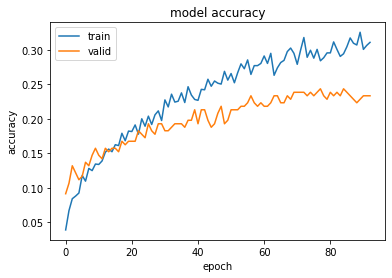

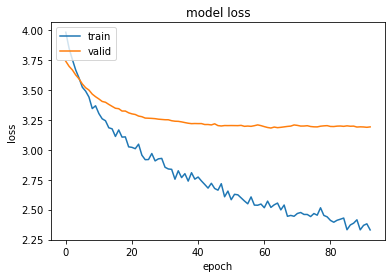

In [42]:
# Training curves
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper left')
plt.show()

In [43]:
# References 
# http://www.dna.bio.keio.ac.jp/smiles/
# https://github.com/pharmbio/dl_quantmap/tree/master/cross_validation/CNN